In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import os
import random


### Evaluate results on COCO format unsing the COCO API

In [12]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

#load ground truth
coco_gt = COCO("auair2019/splits/instances_val.json")
# load predictions
coco_dt = coco_gt.loadRes("val_predictions.json")

# evaluation
coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()


loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.14s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.76s).
Accumulating evaluation results...
DONE (t=0.68s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.051
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.136
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.076
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.082
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.121
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

In [13]:
import json

with open("val_predictions.json", "r") as f:
    results_dict = json.load(f)


In [14]:
from auair_dataset import AUAirCocoDataset
from transformers import DetrImageProcessor

processor = DetrImageProcessor.from_pretrained("saved_detr_model")

val_dataset = AUAirCocoDataset(
    images_dir="auair2019/images",
    annotation_path="auair2019/splits/instances_val.json",
    processor=processor
)

### Define the visualization function

In [21]:
def visualize_predictions(image_dir, image_id, results_dict, category_mapping, threshold=0.5):
    image_info = val_dataset.image_id_to_info[int(image_id)]
    file_path = os.path.join(image_dir, image_info["file_name"])
    image = Image.open(file_path).convert("RGB")

    preds = results_dict[str(image_id)]
    boxes = preds["boxes"]
    scores = preds["scores"]
    labels = preds["labels"]

    # Draw predictions
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    for box, score, label in zip(boxes, scores, labels):
        if score < threshold:
            continue
        x_min, y_min, x_max, y_max = box
        width = x_max - x_min
        height = y_max - y_min

        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2,
                                 edgecolor="red", facecolor="none")
        ax.add_patch(rect)
        label_name = category_mapping[int(label)]
        ax.text(x_min, y_min - 5, f"{label_name} ({score:.2f})",
                color="white", fontsize=12, backgroundcolor="red")

    plt.axis("off")
    plt.show()

###  Load results and show an image

In [20]:
# Load predictions (dict format)
with open("val_results_dict.json") as f:
    results_dict = json.load(f)

results_dict = {
    str(k): v for k, v in results_dict.items()
}


# Load val dataset to access image metadata
val_dataset = AUAirCocoDataset(
    images_dir="auair2019/images",
    annotation_path="auair2019/splits/instances_val.json",
    processor=None  # not needed for visualization
)

Visualize a random image

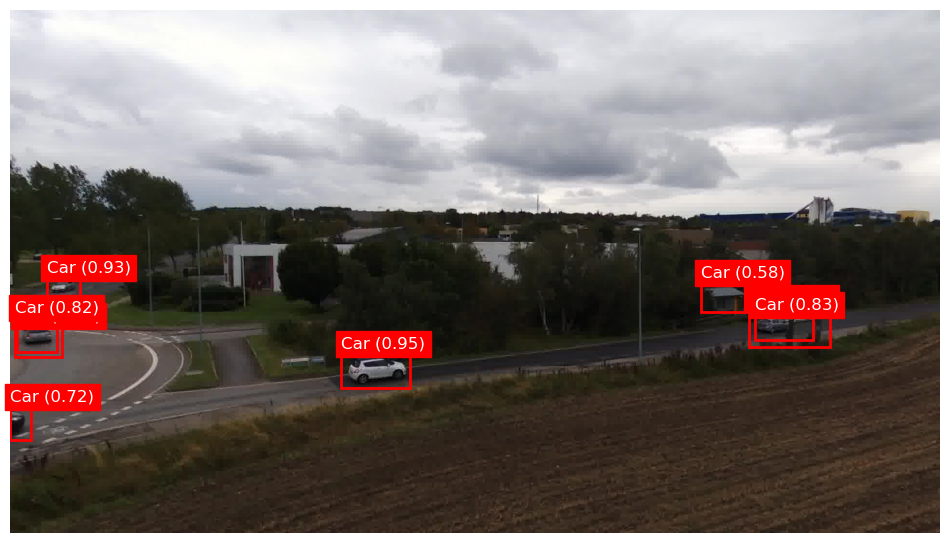

In [22]:
random_image_id = random.choice(list(results_dict.keys()))

visualize_predictions(
    image_dir="auair2019/images",
    image_id=random_image_id,
    results_dict=results_dict,
    category_mapping=val_dataset.categories,
    threshold=0.5
)


# Test Inference

In [ ]:
test_dataset = AUAirCocoDataset(
    images_dir="auair2019/images",
    annotation_path="auair2019/splits/instances_test.json",
    processor=processor
)


In [24]:
from torch.utils.data import DataLoader

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=lambda x: x[0]  # Same as before
)


In [ ]:
from transformers import DetrForObjectDetection, DetrImageProcessor
import torch

# Load fine-tuned model and processor
model = DetrForObjectDetection.from_pretrained("saved_detr_model")
processor = DetrImageProcessor.from_pretrained("saved_detr_model")

# Set model to eval mode and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()


c:\Users\delfi\anaconda3\envs\normal\Lib\site-packages\torch\nn\modules\module.py:2400: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
c:\Users\delfi\anaconda3\envs\normal\Lib\site-packages\torch\nn\modules\module.py:2400: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
c:\Users\delfi\anaconda3\envs\normal\Lib\site-packages\torch\nn\modules\module.py:2400: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current 

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

In [29]:
from tqdm import tqdm
# Run inference on the test set and save results
test_results_dict = {}
model.eval()

for batch in tqdm(test_loader, desc="Running inference on test set"):
    pixel_values = batch["pixel_values"].unsqueeze(0).to(device)
    pixel_mask = batch["pixel_mask"].unsqueeze(0).to(device)
    image_id = batch["labels"][0]["image_id"].item()

    with torch.no_grad():
        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    results = processor.post_process_object_detection(
        outputs,
        target_sizes=[batch["labels"][0]["orig_size"]],
        threshold=0.5
    )[0]

    boxes = results["boxes"].tolist()
    scores = results["scores"].tolist()
    labels = results["labels"].tolist()

    test_results_dict[image_id] = {
        "boxes": boxes,
        "scores": scores,
        "labels": labels
    }


Running inference on test set: 100%|██████████| 9847/9847 [46:09<00:00,  3.56it/s]


In [30]:
import json

# Convert test_results_dict into COCO-style format
coco_test_results = []
for image_id, preds in test_results_dict.items():
    for box, score, label in zip(preds["boxes"], preds["scores"], preds["labels"]):
        x_min, y_min, x_max, y_max = box
        width = x_max - x_min
        height = y_max - y_min

        coco_test_results.append({
            "image_id": image_id,
            "category_id": label,
            "bbox": [x_min, y_min, width, height],
            "score": score
        })

# Save the predictions
with open("test_predictions.json", "w") as f:
    json.dump(coco_test_results, f)

print("test_predictions.json saved.")


test_predictions.json saved.
